In [1]:
# default_exp datasource

In [61]:
# export
import pandas as pd
import numpy as np
import requests
import json
import os
from datetime import datetime

In [62]:
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)  # 设置显示数据的最大列数，防止出现省略号…，导致数据显示不全
pd.set_option('expand_frame_repr', False)  # 当列太多时不自动换行
import matplotlib.pyplot as plt
%matplotlib inline
# 支持中文显示
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

# stock_dict

In [27]:
# export
stock_dict = {
    # 
    '大盘': 'sh000001',
    '上证50': 'sh510050',
    '沪深300': 'sh510300',
    '军工ETF': 'sh512660',
    '证券ETF': 'sh512880',
    '银行ETF': 'sh512800',
    '环保ETF': 'sh512580',
    '医药ETF': 'sh512010',
    '红利ETF': 'sh510880',
    '消费ETF': 'sh510150',
    '传媒ETF': 'sh512980',
    '科技ETF': 'sh515000',
    '半导体': 'sh512480',
    '信息技术ETF': 'sz159939',
    '通信ETF': 'sh515880',
    '国债ETF': 'sZ511010',
    '黄金ETF': 'sh518880',
    '500ETF': 'sh510500',
    '创业板ETF': 'sz159915',
}

In [28]:
# export
class DataSource(object):
    def __init__(self, code, startDate=None, endDate=None, dataLen=None, verbose=True, plot=False, keepRowData=False):
        """

        :keepRowData: bool. 是否保留self._rawData
        """
        if code in stock_dict:
            code = stock_dict[code]
        self._rawData = self.fetch(
            code, startDate, endDate, dataLen, verbose)  # 直接得到的未经处理原始数据
        if keepRowData:
            data = self._rawData.copy()
        else:
            data = self._rawData
        self.data = self.transform(data)  # 标准数据

    def fetch(self, code, startDate=None, endDate=None, dataLen=None):
        """
        从数据源获取数据，需要子类重新实现
        """
        return pd.DataFrame()

#     def transform(self, raw_data):
#         """
#         把fetch到的原始数据转换为标准数据，需要子类重新实现
#         """
#         return pd.DataFrame()
    def transform(self, raw_data):
        """
        把fetch到的原始数据转换为标准数据，需要子类重新实现
        """
        _tmp = raw_data
        _tmp['t'] = _tmp.close.shift(1)
        _tmp['close_pct'] =(_tmp.close / _tmp.t - 1).map(lambda x: round(x, 3), na_action='ignore')
        _tmp['close_pct_log'] =(_tmp.close / _tmp.t).map(lambda x: round(np.log(x), 3), na_action='ignore')
        
        # 振幅
        _tmp['swing'] = ((_tmp.high - _tmp.low) / _tmp.t).map(lambda x: round(x, 3), na_action='ignore')
        _tmp.loc[_tmp.close_pct < 0, 'swing'] =  _tmp.loc[_tmp.close_pct < 0, 'swing'] * (-1)
        
        _tmp['t'] = _tmp.volume.shift(1)
        _tmp['volume_pct'] =(_tmp.volume / _tmp.t - 1).map(lambda x: round(x, 3), na_action='ignore')
        _tmp['volume_pct_log'] =(_tmp.volume / _tmp.t).map(lambda x: round(np.log(x), 3), na_action='ignore')
        
        def new_high(s):
            return int(s.iloc[-1]>=s.iloc[:-1].max())
        def new_low(s):
            return int(s.iloc[-1]<=s.iloc[:-1].min())
        for d in [
#             3, 
#             5, 
#             10, 
            20, 60, 120]:
            for c in 'close volume'.split():
                # 均线
                _tmp[f'{c}_ma{d}'] = _tmp[c].rolling(d).mean()
                # 当前值偏离均值的程度
                _tmp[f'{c}_ma{d}_diff_pct'] = ((_tmp[c] - _tmp[f'{c}_ma{d}'])/_tmp[f'{c}_ma{d}']).map(lambda x: round(x, 3), na_action='ignore')
                # 均值的斜率
                _tmp['t1'] = _tmp[f'{c}_ma{d}'].shift(1)
                _tmp['t2'] = _tmp[f'{c}_ma{d}'].shift(2)
                _tmp['t3'] = _tmp[f'{c}_ma{d}'].shift(2)
                _tmp[f'{c}_ma{d}_grad1'] = _tmp[f'{c}_ma{d}']/_tmp['t1']
                _tmp[f'{c}_ma{d}_grad2'] = _tmp[f'{c}_ma{d}']/((_tmp['t2']+_tmp['t3'])/2)
                _tmp[f'{c}_ma{d}_grad12_diff'] = _tmp[f'{c}_ma{d}_grad1'] - _tmp[f'{c}_ma{d}_grad2']
                
                # 累计涨幅
                _tmp[f'{c}_pct_log_sum{d}'] = _tmp[f'{c}_pct_log'].rolling(d).sum()
                del _tmp[f'{c}_ma{d}']
            # high > 近n日高点 or low 跌破 近 n日低点
            _tmp[f'high_new_{d}'] = _tmp[f'high'].rolling(d).agg(new_high)
            _tmp[f'low_new_{d}'] = _tmp[f'low'].rolling(d).agg(new_low)
            
            _tmp[f'close_high_new_{d}'] = _tmp[f'close'].rolling(d).agg(new_high)
            _tmp[f'close_low_new_{d}'] = _tmp[f'close'].rolling(d).agg(new_low)
            
            # 平均振幅
            _tmp[f'swing_ma{d}'] = _tmp['swing'].rolling(d).mean()
                
        del _tmp['t'], _tmp['t1'], _tmp['t2'], _tmp['t3']
        return _tmp

## SinaDataSource

In [29]:
# export
class SinaDataSource(DataSource):
    def fetch(self, code, startDate=None, endDate=None, dataLen=None, verbose=False, plot=False):
        
        return get_hist_k_data(code, startDate, endDate, dataLen, verbose, plot)

### get_hist_k_data(code, datalen)
获取最近datalen天的code的行情数据

In [25]:
(pd.to_datetime('2020-11-10') - pd.to_datetime('20001010')).days

7336

In [26]:
(datetime.now() - pd.to_datetime('20001010')).days

7221

In [39]:
(datetime.now() - pd.to_datetime('20001010'))

Timedelta('7221 days 07:54:32.166605')

In [52]:
end_date = pd.to_datetime('20001010')

In [54]:
end_date.strftime('%Y%m%d')

'20001010'

In [46]:
# export
def get_hist_k_data(code, start_date=None, end_date=None, datalen=None, verbose=False, plot=False):
    """
    
    """
    if end_date:
        end_date = pd.to_datetime(end_date)
    else:
        end_date = datetime.now()
    if start_date:
        datalen = (end_date - pd.to_datetime(start_date)).days
        print(datalen)
    if datalen is None: 
        return None
    print(f'code:{code}, start_date: {start_date}, end_date: {end_date.strftime("%Y%m%d")}, datalen: {datalen}')
    r = requests.get('http://money.finance.sina.com.cn/quotes_service/api/json_v2.php/'
                     +'CN_MarketData.getKLineData?symbol={}&scale=240&ma=no&datalen={}'.format(code, datalen))
    rs = r.text
    cols_num = ['open', 'high', 'low', 'close', 'volume']
    cols = ['day'] + cols_num
    df1 = pd.DataFrame(json.loads(rs))
    df1.loc[:, cols_num] = df1.loc[:, cols_num].applymap(float)
    df1.loc[:, 'day'] = pd.to_datetime(df1.day)
    df1 = df1[(start_date<=df1.day)&(df1.day<=end_date)]
    df1.set_index('day', inplace=True)
    if verbose:
        print(df1.head(2))
        print(df1.tail(2))
    if plot:
        df1.close.plot()
        
    return df1

870
               open     high      low    close       volume
day                                                        
2018-03-01  3235.09  3280.15  3228.59  3273.76  15909832000
2018-03-02  3248.45  3269.94  3242.27  3254.53  15086106300
               open     high      low    close       volume
day                                                        
2020-07-16  3356.36  3373.53  3209.73   3210.1  49061312300
2020-07-17   3214.4  3252.78  3181.28  3214.13  35965241300


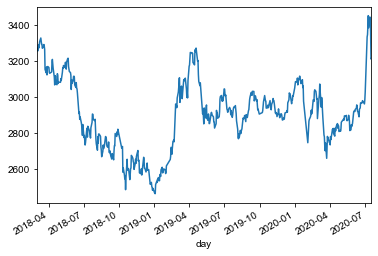

In [49]:
df = get_hist_k_data(stock_dict['大盘'], start_date='20180301', verbose=True, plot=True)

870
            open   high    low  close     volume
day                                             
2018-03-01     4  4.067  3.993  4.049  118636949
2018-03-02  4.02  4.043  4.008  4.022   90614682
            open   high    low  close      volume
day                                              
2020-07-16  4.79  4.828   4.55  4.556  1289918063
2020-07-17  4.57  4.654  4.541  4.605   904292349


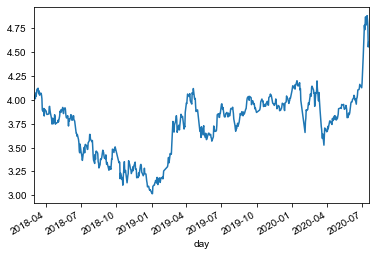

In [47]:
df = get_hist_k_data('sh510300', start_date='20180301', verbose=True, plot=True)

## ZqbDataSource

In [63]:
# export
class ZqbDataSource(DataSource):
    def fetch(self, code, startDate=None, endDate=None, dataLen=None, verbose=False, plot=False):
        import baostock as bs
        # 登陆系统
        lg = bs.login()
        # 显示登陆返回信息
        print('login respond error_code:'+lg.error_code)
        print('login respond  error_msg:'+lg.error_msg)
        # 详细指标参数，参见“历史行情指标参数”章节
        rs = bs.query_history_k_data_plus(code,
            "date,open,high,low,close,volume",
            start_date=startDate,
                                      end_date=endDate, 
                                          frequency="d",
                                         adjustflag='2'
                                         )
        # 打印结果集
        data_list = []
        while (rs.error_code == '0') & rs.next():
            # 获取一条记录，将记录合并在一起
            data_list.append(rs.get_row_data())
        df1 = pd.DataFrame(data_list, columns=rs.fields)
        df1.columns = "day,open,high,low,close,volume".split(',')
        cols_num = ['open', 'high', 'low', 'close', 'volume']
        df1.loc[:, cols_num] = df1.loc[:, cols_num].applymap(float)
        df1 = df1[df1.volume>1]  # zqb取数会把交易日 但是stock停牌等情况的情况下 vol=0
        df1.loc[:, 'day'] = pd.to_datetime(df1.day)
        df1 = df1.set_index('day')
        if verbose:
            print(df1.head(2))
            print(df1.tail(2))
        if plot:
            df1.close.plot()
        return df1


In [64]:
zqb = ZqbDataSource('sh.600660', 
    startDate='2010-01-01', verbose=True, plot=True)

login success!
login respond error_code:0
login respond  error_msg:success
               open     high      low    close       volume
day                                                        
2010-01-04  9.45037  9.51338  9.27397  9.30547  1.67244e+07
2010-01-05  9.30547  9.38107  8.95896  9.10386   3.5347e+07
             open   high    low  close       volume
day                                                
2020-07-23  24.88  24.88     24  24.58  3.40344e+07
2020-07-24   24.5   24.5  23.03  23.32   3.4059e+07


# zqb
https://zhuanlan.zhihu.com/p/54299970

http://baostock.com/baostock/index.php/%E9%A6%96%E9%A1%B5

In [796]:
# !pip install baostock

     |████████████████████████████████| 61kB 399kB/s eta 0:00:01


In [47]:
import baostock as bs
# 登陆系统
lg = bs.login()
# 显示登陆返回信息
print('login respond error_code:'+lg.error_code)
print('login respond  error_msg:'+lg.error_msg)

login success!
login respond error_code:0
login respond  error_msg:success


In [48]:
# 详细指标参数，参见“历史行情指标参数”章节
rs = bs.query_history_k_data_plus("sh.600660",
#     "date,code,open,high,low,close,preclose,volume,amount,pctChg",
            "date,open,high,low,close,volume",
    start_date='2010-01-01',
#                               end_date='2017-06-30', 
                                  frequency="d",
                                 adjustflag='2'
                                 )
print('query_history_k_data_plus respond error_code:'+rs.error_code)
print('query_history_k_data_plus respond  error_msg:'+rs.error_msg)

query_history_k_data_plus respond error_code:0
query_history_k_data_plus respond  error_msg:success


In [49]:
rs

In [50]:
# 打印结果集
data_list = []
while (rs.error_code == '0') & rs.next():
    # 获取一条记录，将记录合并在一起
    data_list.append(rs.get_row_data())
result = pd.DataFrame(data_list, columns=rs.fields)

In [51]:
result.dtypes

date      object
open      object
high      object
low       object
close     object
volume    object
dtype: object

In [53]:
result.volume.map(float).describe()

count    2.566000e+03
mean     1.536948e+07
std      1.261536e+07
min      0.000000e+00
25%      7.640526e+06
50%      1.148941e+07
75%      1.843124e+07
max      1.102810e+08
Name: volume, dtype: float64

In [56]:
result[result.volume.map(float)<1]

,date,open,high,low,close,volume
407,2011-09-05,6.1047745000,6.1047745000,6.1047745000,6.1047745000,0
513,2012-02-17,5.8105685000,5.8105685000,5.8105685000,5.8105685000,0
572,2012-05-17,5.8373145000,5.8373145000,5.8373145000,5.8373145000,0


In [57]:
result.loc[407]

date        2011-09-05
open      6.1047745000
high      6.1047745000
low       6.1047745000
close     6.1047745000
volume               0
Name: 407, dtype: object

In [54]:
result.head(20)

,date,open,high,low,close,volume
0,2010-01-04,9.4503750000,9.5133775000,9.2739680000,9.3054692500,16724424
1,2010-01-05,9.3054692500,9.3810722500,8.9589555000,9.1038612500,35346968
2,2010-01-06,9.1038612500,9.1983650000,8.9337545000,9.0534592500,44608991
3,2010-01-07,9.0093575000,9.0408587500,8.5557395000,8.6187420000,46724393
4,2010-01-08,8.5683400000,8.5683400000,8.2848287500,8.4927370000,33071743
5,2010-01-11,8.5872407500,8.6817445000,8.1903250000,8.3100297500,38053995
6,2010-01-12,8.3667320000,8.7573475000,8.3163300000,8.7447470000,37403294
7,2010-01-13,8.5053375000,8.6943450000,8.3667320000,8.4297345000,37135640
8,2010-01-14,8.5116377500,8.7951490000,8.4423350000,8.7510472500,45714976
9,2010-01-15,8.7951490000,8.9904567500,8.7636477500,8.9085535000,35303588


In [24]:
result.tail()

,date,code,open,high,low,close,preclose,volume,amount,pctChg
2561,2020-07-20,sh.600660,23.7932730000,25.3082732400,23.3271190800,25.1431770600,23.3271190800,63556348,1611643758.0000,7.785200
2562,2020-07-21,sh.600660,24.9489462600,26.4930811200,24.8615424000,25.3762540200,25.1431770600,50403953,1329708295.6000,0.927000
2563,2020-07-22,sh.600660,25.4442348000,25.7355810000,24.9683693400,25.2500040000,25.3762540200,35886613,936983046.2200,-0.497500
2564,2020-07-23,sh.600660,24.8800000000,24.8800000000,24.0000000000,24.5800000000,25.2500000000,34034353,831366119.6300,-2.653500
2565,2020-07-24,sh.600660,24.5000000000,24.5000000000,23.0300000000,23.3200000000,24.5800000000,34059031,807187050.5700,-5.126100


## 上证50成分股

In [65]:
# 登陆系统
lg = bs.login()
# 显示登陆返回信息
print('login respond error_code:'+lg.error_code)
print('login respond  error_msg:'+lg.error_msg)

# 获取上证50成分股
rs = bs.query_sz50_stocks()
print('query_sz50 error_code:'+rs.error_code)
print('query_sz50  error_msg:'+rs.error_msg)

# 打印结果集
sz50_stocks = []
while (rs.error_code == '0') & rs.next():
    # 获取一条记录，将记录合并在一起
    sz50_stocks.append(rs.get_row_data())
result = pd.DataFrame(sz50_stocks, columns=rs.fields)

login success!
login respond error_code:0
login respond  error_msg:success
query_sz50 error_code:0
query_sz50  error_msg:success


In [66]:
result.shape

(50, 3)

In [68]:
result.head()

,updateDate,code,code_name
0,2020-07-20,sh.600000,浦发银行
1,2020-07-20,sh.600009,上海机场
2,2020-07-20,sh.600016,民生银行
3,2020-07-20,sh.600028,中国石化
4,2020-07-20,sh.600030,中信证券


# nbexport

In [9]:
from nbdev.export import *
notebook2script('0datasource.ipynb')

Converted 0datasource.ipynb.
